# Data Project: Employment Shares in Denmark 

## Introduction 

Our data project seeks to investigate the development in the employment in Denmark across regions and gender.
To do so, we import the table RAS201 from Statistics Denmark. The tabel shows data from 2008-2017. It specifically gives an overview of the amount of people in different socio economical groups (Employed, unemployed or outside labour force) within different age groups, ancestry groups and areas (City, municipality or region). For this analysis, we are interested in region, gender and employment status.

## Import data 

In [1]:
# Importing relevant packages
import pandas as pd
import pydst
dst = pydst.Dst(lang='en')
import matplotlib.pyplot as plt

We import the table RAS201 from Statistics Denmark by using the pydst package (See Read me-file for instructions on how to download pydst). All variables are imported, which is specified by the '*'

Since we import more than 300.000 rows it might take some time to import the data from Statictics Denmark. 

In [2]:
# Import data 
Emp = dst.get_data(table_id = 'RAS201', variables = {'OMRÅDE':['*'], 'TID':['*'], 'ALDER':['*'], 'HERKOMST':['*'], 'KØN':['*'], 'SOCIO': ['*']})

In [3]:
# Show the first 5 rows of data in the dataset Emp
Emp.head()

,OMRÅDE,TID,ALDER,HERKOMST,KØN,SOCIO,INDHOLD
0,Horsens,2014,Under 16 years,Descendants from non-western countries,Women,Outside the labour force,509
1,Horsens,2011,Under 16 years,Descendants from non-western countries,Men,Outside the labour force,489
2,Horsens,2012,Under 16 years,Descendants from non-western countries,Men,Outside the labour force,501
3,Horsens,2013,Under 16 years,Descendants from non-western countries,Men,Outside the labour force,490
4,Aarhus,2012,35-39 years,Descendants from non-western countries,Women,Employed,36


The first line of data in the tabel above thus shows us that in 2014 there were 509 women under 16 in Horsens who descends from non-western countries that was outside the labour force. 

## Delete and rename columns 

We delete the columns indicating age, gender and ancestry since we are only interested in the development in the overall employment shares across the different regions of Denmark and employment shares dependent on gender.

In [4]:
# Delete columns that are not needed 
for v in ['ALDER','HERKOMST']: 
    del Emp[v]

Furthermore we rename the remaining variables (columns). 

In [5]:
# Rename remaining columns
Emp = Emp.rename(columns = {'TID':'Year', 'OMRÅDE': 'Region', 'SOCIO': 'Status', 'INDHOLD': 'Num_pers','KØN':'Sex'})

# Show 5 first rows of data to get an overview of out manipulated data
Emp.head()

,Region,Year,Sex,Status,Num_pers
0,Horsens,2014,Women,Outside the labour force,509
1,Horsens,2011,Men,Outside the labour force,489
2,Horsens,2012,Men,Outside the labour force,501
3,Horsens,2013,Men,Outside the labour force,490
4,Aarhus,2012,Women,Employed,36


## Aggregate data 

We would like to aggregate the data such that we have the employment share in each region (and in all Denmark) per year, per social economical status and per gender.
This is done by firstly using a Regex code to create a new variable (I). It will return False, if the row contains a region or All Denmark and True if not (hence true if the area refers to a city or municipality).

In [6]:
# Creating dummy with Regex to seperate regions and total from the remaining data
I = Emp['Region'].str.contains(r'^(?:(?!Region|All Denmark).)*$') 
I.head()

0    True
1    True
2    True
3    True
4    True
Name: Region, dtype: bool

In [7]:
# We drop all the rows that are not a region in our dataset Emp, thus the rows containing True in I
Emp.drop(Emp[I].index, inplace=True)    
Emp.head()

,Region,Year,Sex,Status,Num_pers
3048,Region Nordjylland,2008,Women,Outside the labour force,5
3049,Region Nordjylland,2009,Women,Outside the labour force,3
3050,Region Nordjylland,2010,Women,Outside the labour force,4
3051,Region Nordjylland,2008,Men,Outside the labour force,5
3052,Region Nordjylland,2009,Men,Outside the labour force,3


We choose to remove all persons outside the labour force, as we seek to calculate only the employment share of the labor force. 
To delete people outside the labour force we create a new table only containing rows where people are employed or unemployed

In [8]:
# Creating a dummy for everyone inside labour force "Inside LF (Labor Force)"
Inside_LF = Emp['Status']!='Outside the labour force' 
Inside_LF.head()

3048    False
3049    False
3050    False
3051    False
3052    False
Name: Status, dtype: bool

In [9]:
# Create a table only containing people inside labor force
LF = Emp[Inside_LF]
LF.head()

,Region,Year,Sex,Status,Num_pers
12704,Region Midtjylland,2013,Men,Employed,31
12705,Region Midtjylland,2014,Men,Employed,33
12706,Region Midtjylland,2011,Women,Employed,11
12707,Region Midtjylland,2012,Women,Employed,12
12708,Region Midtjylland,2013,Women,Employed,12


We can now aggregate our data to region per year for different socioeconomical status (employed or unemployed) and for gender. This is done by aggregating over our new variable LF that only contains people in the labour force. 

In [10]:
# Aggregating data by region, year, status and sex
Agg_Emp = LF.groupby(['Region', 'Year', 'Status','Sex'])['Num_pers'].sum().reset_index()
Agg_Emp.head()

,Region,Year,Status,Sex,Num_pers
0,All Denmark,2008,Employed,Men,1493769
1,All Denmark,2008,Employed,Women,1351045
2,All Denmark,2008,Unemployed,Men,35602
3,All Denmark,2008,Unemployed,Women,28607
4,All Denmark,2009,Employed,Men,1410785


In [14]:
# Aggregating data to calculate "total number of persons inside labor force"
TOT = Agg_Emp.groupby(['Region', 'Year','Sex'])['Num_pers'].sum().reset_index()
TOT.head()

,Region,Year,Sex,Num_pers
0,All Denmark,2008,Men,1529371
1,All Denmark,2008,Women,1379652
2,All Denmark,2009,Men,1491299
3,All Denmark,2009,Women,1364483
4,All Denmark,2010,Men,1481206


Secondly we create a table with the sum of employees in each region and in all Denmark. 

In [22]:
# Creating a dummy of all people with status "employed"
Status_Emp = Agg_Emp['Status'] == 'Employed'

# Creating a subset of data only containing person with status "employed"
Agg_Emp_New = Agg_Emp[Status_Emp]

# Aggregating the subset of data created above on region, year and sex
TOT_Emp = Agg_Emp_New.groupby(['Region', 'Year','Sex'])['Num_pers'].sum().reset_index()
TOT_Emp.head()

,Region,Year,Sex,Num_pers
0,All Denmark,2008,Men,1493769
1,All Denmark,2008,Women,1351045
2,All Denmark,2009,Men,1410785
3,All Denmark,2009,Women,1314939
4,All Denmark,2010,Men,1404274


## Merging tables

Next, we join the two newly created tables together by merging on the variables "Region", "Sex" and "Year". 

In [23]:
# Using an inner join to join the data together we merge all the common rows there are in our two tables
JoinTotal = pd.merge(TOT_Emp.reset_index(),TOT.reset_index(),how='inner',on=['Region','Year','Sex'])
JoinTotal.head()

,index_x,Region,Year,Sex,Num_pers_x,index_y,Num_pers_y
0,0,All Denmark,2008,Men,1493769,0,1529371
1,1,All Denmark,2008,Women,1351045,1,1379652
2,2,All Denmark,2009,Men,1410785,2,1491299
3,3,All Denmark,2009,Women,1314939,3,1364483
4,4,All Denmark,2010,Men,1404274,4,1481206


In [24]:
# Renaming columns
JoinTotal = JoinTotal.rename(columns = {'Num_pers_x':'Employed', 'Num_pers_y':'Population'})

# dropping the "extra" index columns
JoinTotal = JoinTotal.drop(columns = ['index_x','index_y'])
JoinTotal.head()

,Region,Year,Sex,Employed,Population
0,All Denmark,2008,Men,1493769,1529371
1,All Denmark,2008,Women,1351045,1379652
2,All Denmark,2009,Men,1410785,1491299
3,All Denmark,2009,Women,1314939,1364483
4,All Denmark,2010,Men,1404274,1481206


## Analysis of employment dependent on region

Next we create a subset of data to create charts that display the evolution of the employment in Denmark the past 10 year disregarding gender, but only focusing on regions.

In [27]:
# First subset disregards sex, hence, we drop the column "Sex"
Subset_nosex = JoinTotal.drop(columns = 'Sex')

# Next aggregation data such that it is grouped by region and year
Subset1 = Subset_nosex.groupby(['Region','Year']).sum().reset_index()
Subset1.head()

,Region,Year,Employed,Population
0,All Denmark,2008,2844814,2909023
1,All Denmark,2009,2725724,2855782
2,All Denmark,2010,2704542,2836600
3,All Denmark,2011,2698418,2824217
4,All Denmark,2012,2684840,2820038


### Calculating employment shares in regions

We calculate the employment share in each region and in All Denmark by dividing the total number of employed people with the total number of people in the labour force. 

In [28]:
# Creating a new column with the calculation of employment shares in pct.
Subset1['Employ_share'] = Subset1.Employed/Subset1.Population*100
Subset1.head()

,Region,Year,Employed,Population,Employ_share
0,All Denmark,2008,2844814,2909023,97.792764
1,All Denmark,2009,2725724,2855782,95.445801
2,All Denmark,2010,2704542,2836600,95.344497
3,All Denmark,2011,2698418,2824217,95.545703
4,All Denmark,2012,2684840,2820038,95.205809


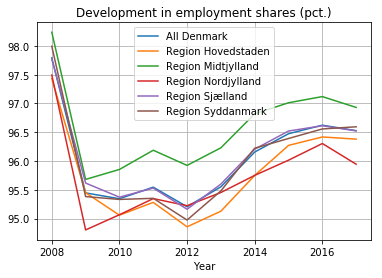

In [29]:
# We plot the evolution of employment shares in the different regions and in all of Denmark
Subset1.set_index('Year').groupby('Region')['Employ_share'].plot(legend=True, grid=True, title='Development in employment shares (pct.)');

## Creating an interactive line chart

We also create a line chart with a dropdown menu where it is possible to only look at one region at the time. This allows for the opportunity to consider the development in each region or in all Denmark individually. 

In [32]:
# Importen widget to create an interactive figure
from ipywidgets import interact

# Defining a function to plot
def draw_graph(region):
    Graph_Data = Subset1.loc[Subset1['Region'] == region,:]
    Graph_Data.set_index('Year').groupby('Region')['Employ_share'].plot(legend=True, grid=True, title='Development in Employment Shares (pct.)');

# Next we create an interactive line chart which displays the development of employment shares grouped by the regions of Denmark
interact(draw_graph, region=['All Denmark', 'Region Syddanmark','Region Sjælland','Region Nordjylland','Region Midtjylland','Region Hovedstaden']);


interactive(children=(Dropdown(description='region', options=('All Denmark', 'Region Syddanmark', 'Region Sjæl…

From the line chart above it can be concluded that the delevopment of the employment shares follows the same pattern throughout all regions of Denmark. The employment share in Denmark was noticeably influenced by the Financial Crisis in 2008-2009. 
Region Midtjylland has an overall higher level of employment compared with the other regions. 
In 2012 it is very clear that the employment rose in all regions, the employment share has been rising in all regions until 2016 where it fell a little. 

## Comparing employment shares for women and men

To compare men and women, we need to create two subsets of data for respectivle men and women and then merge these, such that the number of employed men and women is defined by its own column.

In [33]:
# Creating a subset of data only regarding women
Women = JoinTotal['Sex']=='Women'
JoinWomen = JoinTotal[Women]
JoinWomen.head()

,Region,Year,Sex,Employed,Population
1,All Denmark,2008,Women,1351045,1379652
3,All Denmark,2009,Women,1314939,1364483
5,All Denmark,2010,Women,1300268,1355394
7,All Denmark,2011,Women,1287836,1346594
9,All Denmark,2012,Women,1280697,1344703


In [34]:
# Creating a subset of data only regarding men
Men = JoinTotal['Sex']=='Men'
JoinMen = JoinTotal[Men]
JoinMen.head()

,Region,Year,Sex,Employed,Population
0,All Denmark,2008,Men,1493769,1529371
2,All Denmark,2009,Men,1410785,1491299
4,All Denmark,2010,Men,1404274,1481206
6,All Denmark,2011,Men,1410582,1477623
8,All Denmark,2012,Men,1404143,1475335


In [35]:
# Join data by using an inner join 
JoinSex = pd.merge(JoinWomen,JoinMen,how='inner',on=['Region','Year'])
JoinSex.head()

,Region,Year,Sex_x,Employed_x,Population_x,Sex_y,Employed_y,Population_y
0,All Denmark,2008,Women,1351045,1379652,Men,1493769,1529371
1,All Denmark,2009,Women,1314939,1364483,Men,1410785,1491299
2,All Denmark,2010,Women,1300268,1355394,Men,1404274,1481206
3,All Denmark,2011,Women,1287836,1346594,Men,1410582,1477623
4,All Denmark,2012,Women,1280697,1344703,Men,1404143,1475335


In [36]:
# Renaming and dropping unnecessary columns
JoinSex = JoinSex.rename(columns = {'Employed_x':'Emp_Women', 'Population_x':'Pop_Women','Employed_y':'Emp_Men','Population_y':'Pop_Men'})
JoinSex_final = JoinSex.drop(columns = ['Sex_x','Sex_y'])
JoinSex_final.head()

,Region,Year,Emp_Women,Pop_Women,Emp_Men,Pop_Men
0,All Denmark,2008,1351045,1379652,1493769,1529371
1,All Denmark,2009,1314939,1364483,1410785,1491299
2,All Denmark,2010,1300268,1355394,1404274,1481206
3,All Denmark,2011,1287836,1346594,1410582,1477623
4,All Denmark,2012,1280697,1344703,1404143,1475335


### Plotting barchart for the employment shares of men and women in Denmark

In [38]:
# Creating a new total to create bar chart
JoinSex_bar = JoinSex_final # renaming dataframe not to overwrite

# Recreating total population
JoinSex_bar['Pop_Tot'] = JoinSex_final.Pop_Women+JoinSex_final.Pop_Men 
JoinSex_bar.head()

,Region,Year,Emp_Women,Pop_Women,Emp_Men,Pop_Men,Pop_Tot
0,All Denmark,2008,1351045,1379652,1493769,1529371,2909023
1,All Denmark,2009,1314939,1364483,1410785,1491299,2855782
2,All Denmark,2010,1300268,1355394,1404274,1481206,2836600
3,All Denmark,2011,1287836,1346594,1410582,1477623,2824217
4,All Denmark,2012,1280697,1344703,1404143,1475335,2820038


In [39]:
# Calculating employment shares of total employment for men and women respectivly to create stacked bar chart
JoinSex_bar['Emp_share_women']=JoinSex_bar['Emp_Women']/JoinSex_bar['Pop_Tot']*100
JoinSex_bar['Emp_share_men']=JoinSex_bar['Emp_Men']/JoinSex_bar['Pop_Tot']*100

# Dropping irrelevant columns
JoinSex_bar_final = JoinSex_bar.drop(columns = ['Region','Emp_Women','Pop_Women','Emp_Men','Pop_Men','Pop_Tot'])
JoinSex_bar_final.groupby(['Year'])['Emp_share_women','Emp_share_men'].sum().reset_index()
JoinSex_bar_final.head()

,Year,Emp_share_women,Emp_share_men
0,2008,46.443256,51.349508
1,2009,46.044796,49.401005
2,2010,45.838962,49.505535
3,2011,45.599754,49.945950
4,2012,45.414175,49.791634


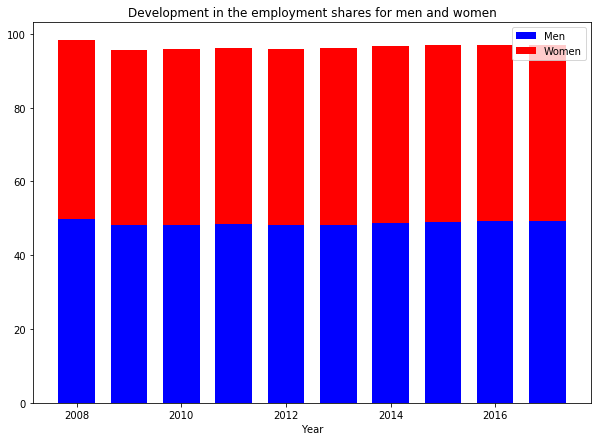

In [50]:
# Plotting stacked bar chart with the data above
plt.figure(figsize=(10,7))
bar_men = JoinSex_bar_final['Emp_share_men'] # Creating bar variable for men
bar_women = JoinSex_bar_final['Emp_share_women'] # Creating bar variable for women
index = JoinSex_bar_final['Year'] # Creating index of time
graph_men=plt.bar(x=index,height=bar_men,width=0.7,color='b') # creating bottom bar
graph_women=plt.bar(x=index,height=bar_women,width=0.7,bottom=bar_men,color='r') # creating bar on top of bottom
plt.legend(['Men','Women'])
plt.xlabel('Year')
plt.title('Development in the employment shares for men and women');

### Plotting an interactive line chart for employment shares for men and women

In [42]:
# Calculate employment shares 
JoinSex_final['Emp_share_Women'] = JoinSex_final.Emp_Women/JoinSex_final.Pop_Women*100
JoinSex_final['Emp_share_Men'] = JoinSex_final.Emp_Men/JoinSex_final.Pop_Men*100
JoinSex_final.head()

,Region,Year,Emp_Women,Pop_Women,Emp_Men,Pop_Men,Pop_Tot,Emp_share_women,Emp_share_men,Emp_share_Women,Emp_share_Men
0,All Denmark,2008,1351045,1379652,1493769,1529371,2909023,46.443256,51.349508,97.926506,97.672115
1,All Denmark,2009,1314939,1364483,1410785,1491299,2855782,46.044796,49.401005,96.369028,94.601083
2,All Denmark,2010,1300268,1355394,1404274,1481206,2836600,45.838962,49.505535,95.932843,94.806124
3,All Denmark,2011,1287836,1346594,1410582,1477623,2824217,45.599754,49.945950,95.636547,95.462916
4,All Denmark,2012,1280697,1344703,1404143,1475335,2820038,45.414175,49.791634,95.240139,95.174520


In [45]:
# Drop columns that are irrelevant 
JoinSex_plot = JoinSex_final.drop(columns = ['Emp_Women','Pop_Women','Emp_Men','Pop_Men'])
JoinSex_plot.head()

,Region,Year,Pop_Tot,Emp_share_women,Emp_share_men,Emp_share_Women,Emp_share_Men
0,All Denmark,2008,2909023,46.443256,51.349508,97.926506,97.672115
1,All Denmark,2009,2855782,46.044796,49.401005,96.369028,94.601083
2,All Denmark,2010,2836600,45.838962,49.505535,95.932843,94.806124
3,All Denmark,2011,2824217,45.599754,49.945950,95.636547,95.462916
4,All Denmark,2012,2820038,45.414175,49.791634,95.240139,95.174520


In [49]:
# Defining function to plot figure
def draw_graph(region):
    Graph_Data = JoinSex_plot.loc[JoinSex_plot['Region'] == region,:]
    Graph_Data.set_index('Year').groupby('Region')['Emp_share_Women'].plot(grid=True,color='r')
    Graph_Data.set_index('Year').groupby('Region')['Emp_share_Men'].plot(grid=True,color='b')
    plt.legend(['Women','Men'])
    plt.title('Employment shares in Denmark dependent on gender')

# Next we create an interactive line chart which displays the development of employment shares grouped by the regions of Denmark
interact(draw_graph, region=['All Denmark', 'Region Syddanmark','Region Sjælland','Region Nordjylland','Region Midtjylland','Region Hovedstaden']);

interactive(children=(Dropdown(description='region', options=('All Denmark', 'Region Syddanmark', 'Region Sjæl…

The employment has been more volatile for men when looking at Denmark in total. It is clear that the drop in employment during the financial crisis was biggest for men. 
Looking at the stacked barchart it can be seen that in general the employment share for men and women has been relatively stabel over the years 2008-2017. 

## Conclusion

From this project it can be concluded that the employment across regions and gender has been remarkably affected by the financial crisis. Furthermore it can be seen from both our analysis that in 2012 the employment started rise but then fell a little in 2016. 